# Prediction with cumul

In [280]:
import math
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import warnings
import torch
warnings.filterwarnings('ignore')
%matplotlib inline

In [281]:
df = pd.read_csv("droppy1.csv", sep=";", parse_dates=True, index_col="day", dayfirst=True) 
df1 = df[['cumul','Jour']]
df1['Jour'] = df1['Jour'].apply(lambda x: 1 if x=='SAM' else 0)
df1.head()

,cumul,Jour
day,,
2021-10-01,105.0,0
2021-10-02,0.0,1
2021-10-03,0.0,0
2021-10-04,144.4,0
2021-10-05,115.3,0


In [282]:
import torch.nn as nn
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout1 = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [283]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [284]:
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [285]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

sc = StandardScaler()
df_sc = sc.fit_transform(df1)

In [286]:
# Splitting data into train and test data
m = int(len(df1)*0.8)
DAY_STEP=14

train_data = df_sc[:m]
test_data = df_sc[m:]

In [287]:
#Building X_train and y_train

X_train = []
y_train = []
for i in range(DAY_STEP, len(train_data)):
    X_train.append(train_data[i-DAY_STEP:i,:])
    y_train.append(train_data[i,0])

X_train, y_train = np.array(X_train), np.array(y_train).reshape(len(y_train),1)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

In [321]:
input_dim = 2
hidden_dim = 256
num_layers = 2
output_dim = 15
num_epochs = 150

In [322]:
#Define the model, the loss function and the optimizer
model= LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.005)

for epoch in range(num_epochs):
    
    y_train_pred = model(X_train)
    loss = torch.sqrt(criterion(y_train_pred, y_train))
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

print("Epoch:", num_epochs, "RMSE:", loss.item())
print('\n')

#Generate predictions for train data 
y_train_pred = model(X_train)

Epoch: 150 RMSE: 0.2641339600086212




In [323]:
predict_train =  sc.inverse_transform(torch.repeat_interleave(y_train_pred,X_train.shape[2],axis=1).detach().numpy())
original_train = sc.inverse_transform(torch.repeat_interleave(y_train,X_train.shape[2],axis=1).detach().numpy())

predict_train = predict_train[:,0]
original_train =original_train[:,0]

predict_train = pd.DataFrame(predict_train, index=df1[DAY_STEP:m].index)
original_train = pd.DataFrame(original_train ,index=df1[DAY_STEP:m].index)

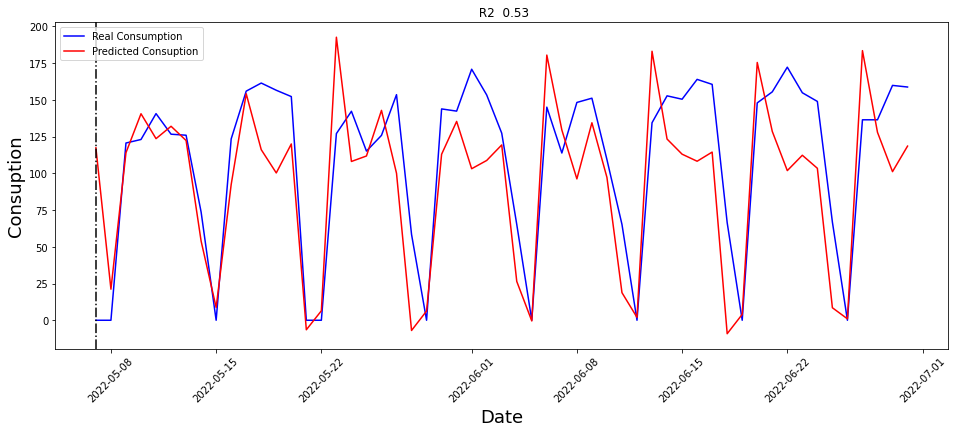

In [324]:
#Building X_test 
inputs = df_sc[len(train_data) - DAY_STEP:,:]
X_test = []

for i in range(DAY_STEP, DAY_STEP+len(test_data)):
    X_test.append(inputs[i-DAY_STEP:i,:])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],X_test.shape[2]))
X_test = torch.from_numpy(X_test).float()

#Generate predictions for test data
predict_test = model(X_test)
predict_test = sc.inverse_transform(torch.repeat_interleave(predict_test,X_train.shape[2],axis=1).detach().numpy())
predict_test = torch.from_numpy(predict_test).float()

real_test = test_data[:,0].reshape(-1,1)
real_test = torch.from_numpy(sc.inverse_transform(np.repeat(real_test,X_train.shape[2],axis=1))).float()

real_test = real_test[:,0]
predicted_test =predict_test[:,0]

predict_test = pd.DataFrame(predicted_test, index=df1[m:].index)
original_test = pd.DataFrame(real_test ,index=df1[m:].index)

train_open = pd.concat((original_train, original_test), axis=0)
test_open = pd.concat((predict_train, predict_test), axis=0)

r2 = r2_loss(predicted_test, real_test)

plt.figure(figsize = (16,6))
plt.plot(original_test, label='Real Consumption', c='b')
plt.plot(predict_test, label='Predicted Consuption', c='r')
plt.axvline(x = df1['cumul'].index[m], c='black', linestyle='-.')
plt.title(" R2 {:5.2f}".format(r2))
plt.xticks(rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Consuption',fontsize=18)
plt.legend()
plt.show()

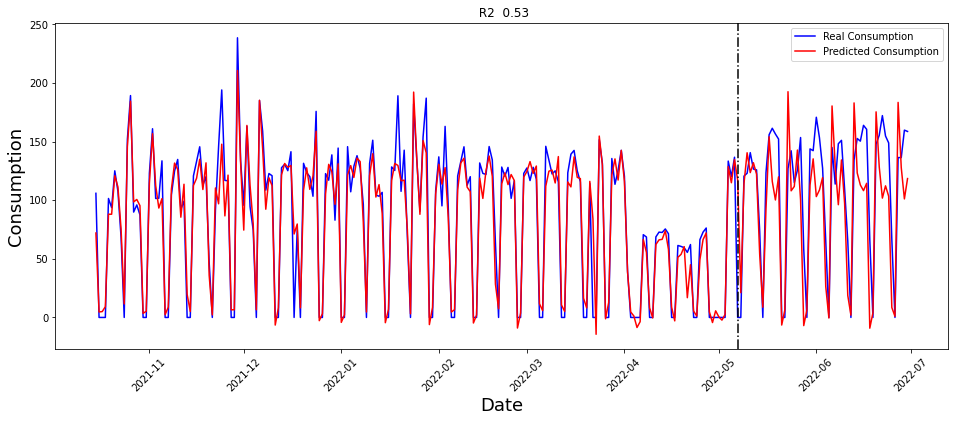

In [327]:
plt.figure(figsize = (16,6))
plt.plot(train_open, label='Real Consumption', c='b')
plt.plot(test_open, label='Predicted Consumption', c='r')
plt.axvline(x = df1['cumul'].index[m], c='black', linestyle='-.')
plt.title(" R2 {:5.2f}".format(r2))
plt.xticks(rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Consumption',fontsize=18)
plt.legend()
plt.show()